# Object Interaction Experiment
Use this notebook to test the object analysis on any video.
**Nothing is saved to disk** — all results show inline here.

In [45]:
# ── CHANGE THIS to test different videos ──────────────────────────────────────
VIDEO_PATH = "/Users/narayanipemmaraju/Documents/Code/DELL_NVDIA_hackathon/Fall_Detection/data/fall-08-cam0_fall_from_chair.mp4"
# VIDEO_PATH = "/full/path/to/another_video.mp4"
# ─────────────────────────────────────────────────────────────────────────────

In [46]:
import cv2
import numpy as np
import json
from pathlib import Path
from IPython.display import display, Image as IPImage
from ultralytics import YOLO

# Load models (runs once)
SCRIPT_DIR = Path(".").resolve()
obj_model  = YOLO(SCRIPT_DIR / "yolov8n.pt")
pose_model = YOLO(SCRIPT_DIR / "yolov8n-pose.pt")
print("Models loaded.")

Models loaded.


In [47]:
# ── CONFIG (tweak and re-run to experiment) ───────────────────────────────────
FALL_ASPECT_THRESHOLD = 0.75   # width/height ratio to count as horizontal
FALL_CONFIRM_FRAMES   = 8      # consecutive horizontal frames to confirm fall
RECOVER_FRAMES        = 30     # upright frames before clearing fall state
TOUCH_IOU_THRESHOLD   = 0.05   # bounding box overlap → "touching"
PROXIMITY_PX          = 100   # pixel distance → "nearby"
PRE_FALL_BUFFER_SEC   = 5.0  # seconds back to look for pre-existing objects
OBJ_CONF_THRESHOLD    = 0.35   # min confidence for object detection
SITTING_VERTICAL_OVERLAP = 0.15
SITTING_HORIZONTAL_TOL   = 0.6

HIGH_RISK   = {"chair", "dining table", "bench", "bed", "sofa", "couch",
               "toilet", "sink", "oven", "refrigerator", "scissors", "knife", "fork"}
MEDIUM_RISK = {"bottle", "cup", "vase", "potted plant", "tv", "laptop",
               "suitcase", "backpack", "remote", "keyboard", "microwave"}
LOW_RISK    = {"book", "cell phone", "mouse", "clock", "pillow", "teddy bear"}

def get_risk(label):
    if label in HIGH_RISK:   return "HIGH"
    if label in MEDIUM_RISK: return "MEDIUM"
    if label in LOW_RISK:    return "LOW"
    return "UNKNOWN"
# ─────────────────────────────────────────────────────────────────────────────

In [48]:
# ── Helpers ───────────────────────────────────────────────────────────────────

def iou(a, b):
    ix1,iy1 = max(a[0],b[0]), max(a[1],b[1])
    ix2,iy2 = min(a[2],b[2]), min(a[3],b[3])
    inter = max(0,ix2-ix1)*max(0,iy2-iy1)
    if inter == 0: return 0.0
    return inter / ((a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter)

def center_dist(a, b):
    ca = ((a[0]+a[2])/2, (a[1]+a[3])/2)
    cb = ((b[0]+b[2])/2, (b[1]+b[3])/2)
    return np.sqrt((ca[0]-cb[0])**2 + (ca[1]-cb[1])**2)

def is_horizontal(box):
    w, h = box[2]-box[0], box[3]-box[1]
    return (w/h > FALL_ASPECT_THRESHOLD) if h > 0 else False

def draw_box(frame, box, label, color, thickness=2):
    x1,y1,x2,y2 = [int(v) for v in box]
    cv2.rectangle(frame, (x1,y1),(x2,y2), color, thickness)
    (tw,th),_ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(frame, (x1,y1-th-6),(x1+tw+6,y1), color, -1)
    cv2.putText(frame, label, (x1+3,y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

def show_frame(frame, title=""):
    """Display a frame inline in the notebook."""
    if title:
        print(title)
    _, buf = cv2.imencode(".jpg", frame)
    display(IPImage(data=buf.tobytes()))

def is_sitting_on(person_box, obj_box):
    px1, py1, px2, py2 = person_box
    ox1, oy1, ox2, oy2 = obj_box

    person_bottom  = py2
    person_width   = px2 - px1
    object_top     = oy1
    object_height  = oy2 - oy1

    vertical_match = (object_top - 20 <= person_bottom <= object_top + object_height * 0.6)
    person_cx        = (px1 + px2) / 2
    obj_cx           = (ox1 + ox2) / 2
    horizontal_match = abs(person_cx - obj_cx) < person_width * SITTING_HORIZONTAL_TOL
    upright          = not is_horizontal(person_box)

    return vertical_match and horizontal_match and upright



print("Helpers ready.")

Helpers ready.


In [49]:
# ── Run analysis (no saving) ──────────────────────────────────────────────────

cap   = cv2.VideoCapture(VIDEO_PATH)
fps   = cap.get(cv2.CAP_PROP_FPS) or 25
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video: {VIDEO_PATH}  |  {total} frames @ {fps:.1f}fps")

# Per-person fall state
horiz_counts  = {}  # track_id → consecutive horizontal frames
upright_counts = {}
fallen_ids    = set()
sitting_log = []

pre_fall_log  = []  # (frame_idx, label, box)
incidents     = []  # collected results
fall_frames   = []  # (frame_idx, annotated_frame) — shown at end

buffer_frames = PRE_FALL_BUFFER_SEC * fps
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Object detection
    obj_results      = obj_model(frame, verbose=False)[0]
    detected_objects = []
    if obj_results.boxes is not None:
        for box in obj_results.boxes:
            cls_id = int(box.cls[0])
            label  = obj_model.names[cls_id]
            if label == "person": continue
            conf = float(box.conf[0])
            if conf < OBJ_CONF_THRESHOLD: continue
            detected_objects.append({"label": label, "box": box.xyxy[0].tolist(), "conf": conf})

    # Rolling pre-fall log
    for obj in detected_objects:
        pre_fall_log.append((frame_idx, obj["label"], obj["box"]))
    cutoff = frame_idx - int(PRE_FALL_BUFFER_SEC * fps) - 1
    pre_fall_log = [(f,l,b) for f,l,b in pre_fall_log if f > cutoff]

    # Pose / fall detection
    pose_results = pose_model(frame, verbose=False)[0]
    if pose_results.boxes is not None:
        for i, box in enumerate(pose_results.boxes):
            tid  = int(box.id[0]) if box.id is not None else i
            pbox = box.xyxy[0].tolist()

            horiz_counts.setdefault(tid, 0)
            upright_counts.setdefault(tid, 0)

            if is_horizontal(pbox):
                horiz_counts[tid]  += 1
                upright_counts[tid] = 0
            else:
                upright_counts[tid] += 1
                horiz_counts[tid]   = 0
                for obj in detected_objects:
                    if is_sitting_on(pbox, obj["box"]):
                        sitting_log.append((frame_idx, tid, obj["label"], obj["box"]))

            sitting_log = [(f,t,l,b) for f,t,l,b in sitting_log if f > cutoff]
                

            # New fall
            if tid not in fallen_ids and horiz_counts[tid] >= FALL_CONFIRM_FRAMES:
                fallen_ids.add(tid)
                fall_time = round(frame_idx / fps, 2)

                # Interaction analysis
                
                print(f"DEBUG sitting_log: {sitting_log}")
                print(f"DEBUG fall frame: {frame_idx}, tid: {tid}")

                pre_sitting = [
                    {"object": l, "last_seen_frame": f,
                     "seconds_before_fall": round((frame_idx - f) / fps, 2)}
                for (f, t, l, b) in sitting_log 
                                ]
                seen = {}
                for s in sorted(pre_sitting, key=lambda x: x["last_seen_frame"], reverse=True):
                    if s["object"] not in seen:
                        seen[s["object"]] = s
                sitting_summary = list(seen.values())


                interactions  = []
                for obj in detected_objects:
                    overlap  = iou(pbox, obj["box"])
                    distance = center_dist(pbox, obj["box"])
                    touching = overlap > TOUCH_IOU_THRESHOLD
                    nearby   = distance < PROXIMITY_PX
                    if not (touching or nearby): continue

                    present_before = any(
                        lbl == obj["label"] and 0 < (frame_idx - f) <= buffer_frames
                        for (f, lbl, _) in pre_fall_log
                    )
                    interactions.append({
                        "object"              : obj["label"],
                        "touching"            : touching,
                        "proximity_px"        : round(distance, 1),
                        "present_before_fall" : present_before,
                        "timing"              : "BEFORE_FALL" if present_before else "AFTER_FALL",
                        "likely_cause"        : present_before and touching,
                        "injury_risk"         : get_risk(obj["label"]),
                    })

                risk_order = {"HIGH":0,"MEDIUM":1,"LOW":2,"UNKNOWN":3}
                interactions.sort(key=lambda x: (not x["touching"], risk_order[x["injury_risk"]]))

                incidents.append({
                    "person_track_id"    : tid,
                    "fall_frame"         : frame_idx,
                    "fall_time_sec"      : fall_time,
                    "object_interactions": interactions,
                    "was_sitting_on": sitting_summary
                })

                # Annotate the fall frame for display
                vis = frame.copy()
                draw_box(vis, pbox, f"FALL Person {tid}", (0,0,220), 3)
                RISK_COLORS = {"HIGH":(0,0,220),"MEDIUM":(0,140,255),"LOW":(0,200,150),"UNKNOWN":(160,160,160)}
                for obj in detected_objects:
                    draw_box(vis, obj["box"],
                             f"{obj['label']} [{get_risk(obj['label'])}]",
                             RISK_COLORS[get_risk(obj["label"])], 1)
                for s in sitting_summary:
                    for obj in detected_objects:
                        if obj["label"] == s["object"]:
                            draw_box(vis, obj["box"], f"WAS SITTING ON: {s['object']}", (255, 100, 0), 3)
                cv2.putText(vis, f"FALL @ {fall_time}s", (20,48),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0,0,255), 3)
                fall_frames.append((frame_idx, vis))

            # Recover
            if tid in fallen_ids and upright_counts[tid] >= RECOVER_FRAMES:
                fallen_ids.discard(tid)

    frame_idx += 1

cap.release()
print(f"\nDone. {len(incidents)} fall(s) detected.")

Video: /Users/narayanipemmaraju/Documents/Code/DELL_NVDIA_hackathon/Fall_Detection/data/fall-08-cam0_fall_from_chair.mp4  |  91 frames @ 30.0fps
DEBUG sitting_log: []
DEBUG fall frame: 40, tid: 0
DEBUG sitting_log: []
DEBUG fall frame: 40, tid: 1

Done. 2 fall(s) detected.


In [50]:
# ── Print results ─────────────────────────────────────────────────────────────
for inc in incidents:
    print(f"\n{'='*55}")
    print(f"FALL — Person {inc['person_track_id']} @ {inc['fall_time_sec']}s  (frame {inc['fall_frame']})")
    print(f"{'='*55}")
    if inc["object_interactions"]:
        for obj in inc["object_interactions"]:
            cause = " ← LIKELY CAUSE" if obj["likely_cause"] else ""
            print(f"  {obj['object']:20s}  touch={str(obj['touching']):5s}  "
                  f"timing={obj['timing']:12s}  risk={obj['injury_risk']}{cause}")
    else:
        print("  No nearby objects detected.")

    print(f"\n  SITTING ON (before fall):")
    if inc["was_sitting_on"]:
        for s in inc["was_sitting_on"]:
            print(f"    {s['object']:20s}  last seen {s['seconds_before_fall']}s before fall")
    else:
        print("    Nothing detected.")


FALL — Person 0 @ 1.33s  (frame 40)
  chair                 touch=True   timing=BEFORE_FALL   risk=HIGH ← LIKELY CAUSE

  SITTING ON (before fall):
    Nothing detected.

FALL — Person 1 @ 1.33s  (frame 40)
  No nearby objects detected.

  SITTING ON (before fall):
    Nothing detected.


Fall at frame 112


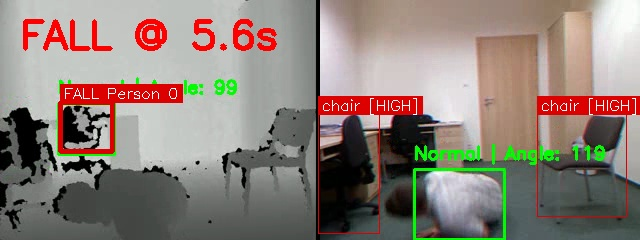

In [7]:
# ── Show annotated fall frames inline ─────────────────────────────────────────
for frame_idx, vis in fall_frames:
    show_frame(vis, title=f"Fall at frame {frame_idx}")

In [8]:
# ── (Optional) Pretty-print full JSON ─────────────────────────────────────────
print(json.dumps(incidents, indent=2))

[
  {
    "person_track_id": 0,
    "fall_frame": 112,
    "fall_time_sec": 5.6,
    "object_interactions": []
  }
]
